In [4]:
# import libraries

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import sys
import os

# Get the current working directory (which should be the directory containing the Jupyter notebook)
current_dir = os.getcwd()

# Construct the absolute path to the DataPreprocessing directory
data_preprocessing_path = os.path.join(current_dir, '..', 'DataPreprocessing')

# Add this path to sys.path
sys.path.append(os.path.abspath(data_preprocessing_path))

from Preprocessing import FeatureExtract, filter_data,time_series_features,hjorth_features, fractal_features, entropy_features, split_window
from DataRetrieve import vui, buon, calm



from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier


In [5]:
vui = split_window(vui)
buon = split_window(buon)
calm = split_window(calm)
vui[1].shape

(7680,)

In [6]:
# renaming

features = np.empty((0,7))
for i in vui:
    feature1 = time_series_features(i)
    feature2 = hjorth_features(i)
    feature3 = fractal_features(i)
    #feature4 = entropy_features(i)
    feature = np.hstack(( feature1, feature2, feature3))
    features = np.vstack((features, feature))
    #print(feature)
    #print(feature.shape)
for i in buon:
    feature1 = time_series_features(i)
    feature2 = hjorth_features(i)
    feature3 = fractal_features(i)
    #feature4 = entropy_features(i)
    feature = np.hstack(( feature1, feature2, feature3))
    features = np.vstack((features, feature))
for i in calm:
    feature1 = time_series_features(i)
    feature2 = hjorth_features(i)
    feature3 = fractal_features(i)
    #feature4 = entropy_features(i)
    feature = np.hstack(( feature1, feature2, feature3))
    features = np.vstack((features, feature))
print(type(features))
features = np.array(features)
print(features.shape)

<class 'numpy.ndarray'>
(1758, 7)


In [7]:
#y = df["stress_level"]
#X = df.drop(["stress_level"], axis= 1)
X = features
#y = pd.concat([pd.Series([0] * len(df)), pd.Series([1] * len(df1)), pd.Series([2] * len(df2))]).values
#X = np.concatenate((time_series_features(vui), time_series_features(buon), time_series_features(calm)))
y = pd.concat([pd.Series([1] * len(vui)), pd.Series([-1] * len(buon)), pd.Series([0] * len(calm))]).values
print(y)

[1 1 1 ... 0 0 0]


In [8]:
if np.isinf(X).any():
  # Handle infinity (e.g., remove rows/columns, replace with specific value)
  raise ValueError("X contains infinite values. Please address before splitting.")

# Check for very large values (optional)
if np.max(np.abs(X)) > 1e10:  # Adjust threshold as needed
  # Consider scaling or normalizing X
  from sklearn.preprocessing import StandardScaler
  scaler = StandardScaler()
  X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state= 42)
knn = KNeighborsClassifier()
knn_model = knn.fit(X_train, y_train)
knn_model

KNeighborsClassifier()

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       151
           1       0.97      0.93      0.95       152
           2       0.00      0.00      0.00         0

   micro avg       0.97      0.95      0.96       303
   macro avg       0.64      0.63      0.64       303
weighted avg       0.97      0.95      0.96       303



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _

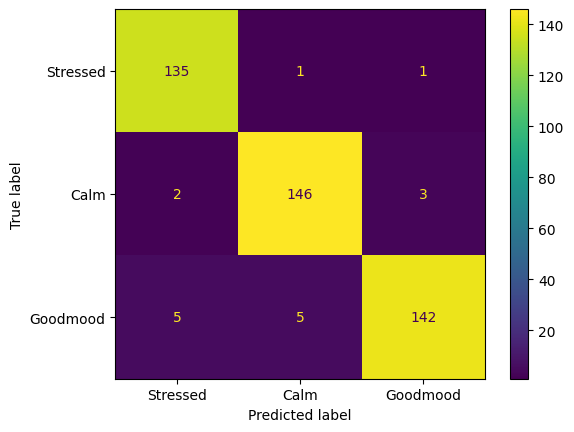

In [9]:
### Statistics and Confusion Matrix display
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = knn_model.predict(X_test)
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=["Stressed", "Calm", "Goodmood"])
disp.plot()
plt.savefig("../Figure/Thai_KNN")
plt.show()

In [10]:
train_score = knn_model.score(X_train, y_train)
test_score = knn_model.score(X_test, y_test)
print("Train accuracy:", train_score)
print("Test accuracy:", test_score)

Train accuracy: 0.9764795144157815
Test accuracy: 0.9613636363636363


In [12]:
knn_model.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [13]:
from sklearn.model_selection import StratifiedKFold


kf = StratifiedKFold(n_splits=10, shuffle=True)
accuracy_list = []
for train_index, test_index in kf.split(X, y):
    # Split data into training and testing sets
    X_train_kf, X_test_kf = X[train_index], X[test_index]
    y_train_kf, y_test_kf = y[train_index], y[test_index]
    knn_model.fit(X_train_kf, y_train_kf)
    
    accuracy = knn_model.score(X_test_kf, y_test_kf)
    accuracy_list.append(accuracy)
    
avg_accuracy = np.mean(accuracy_list)
print("Accuracy of folds:", accuracy_list)
print("K-Fold mean accuracy:", avg_accuracy)

Accuracy of folds: [0.9659090909090909, 0.9545454545454546, 0.9886363636363636, 0.9659090909090909, 0.9488636363636364, 0.9545454545454546, 0.9772727272727273, 0.9772727272727273, 0.96, 0.9828571428571429]
K-Fold mean accuracy: 0.9675811688311686


In [14]:
import pickle
pickle.dump(knn_model, open("../trained_model/KNN.h5", "wb"))
with open('../trained_model/Timescaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)